# Actual code

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%reset -f
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
###############------------------- LOAD MODULES ---------------------#############

from tensorflow.keras.models import model_from_yaml, model_from_json
from tensorflow import keras
# from functions_small_model import *
import pickle, shapely
import numpy as np
import math as mt
import tempfile
import tensorflow as tf
import pickle
from scipy import misc
import glob, csv
from tensorflow.keras import layers
from shapely.geometry import box, Polygon, Point, LinearRing
from shapely.ops import unary_union
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Reshape, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, concatenate, Concatenate, LeakyReLU
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from keras.regularizers import Regularizer
# import keras_gcn
# from keras_gcn import GraphConv
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from sklearn import preprocessing
from numpy import linalg as LA
import pandas as pd
from tensorflow.keras.utils import plot_model
from numpy import matlib
from progressbar import ProgressBar
# import tensorflow_model_optimization as tfmot
from matplotlib import cm
main = "/content/drive/MyDrive/SN Folio/border_model/B-object-rep/"

In [ ]:
# os.chdir('/content/drive/My Drive/SN Folio/border_model/B-object-rep')

In [ ]:
#@title Setup Parameters
data_path = "/content/drive/MyDrive/border_model/Gen_data_for_LV/"
traj1 = "LV_0.3_0.156scaled_30k.pk1"
traj_path = data_path + traj1 #@param {type:"string"}
imgs_path = data_path + "frames_LV_BL_8C1.pk1" #@param {type:"string"}
fol2 = main + "LV_cell/" #@param {type:"string"}

# traj_o = "meshgrid_obj(sh3)_30.pk1" #@param {type:"string"}
# imgs_o = "frames_mesh(obj)(sh3)_bw_30.pk1" #@param {type:"string"}

old_model_n = "train_5_vector" #@param {type:"string"}
# fisher_n = "frames_traj(wo)_bw_20k.pk1" #@param {type:"string"}
epochs = 50 #@param {type:"number"}
lam = 0.0 #@param {type:"number"}
# lr_p = 0.1 #@param {type:"number"}
# lr_m = 0.01 #@param {type:"number"}
units = 32 #@param {type:"number"}
units2 = 64 #@param {type:"number"}
std_dev = 0.3 #@param {type:"number"}
alp = 0 #@param {type:"number"}
bet = 0 #@param {type:"number"}
gam = 1 #@param {type:"number"}
lem = 2   #@param {type:"number"}

new_model_n = "BL_8C_LV_v5_obj_" + str(alp) + "_" + str(bet) + "_" + str(gam) + "_" + str(epochs) + "e_" + "2p" #@param {type:"string"}
mesh_path = "mesh_images_" + new_model_n +"/"

# test_p =  7#@param {type:"number"}
# img_fol = "traj_four_objs_diffW" #@param {type:"string"}


#@markdown ### Model Params
Retrain = False #@param {type:"boolean"}
# retrain_full = False #@param {type:"boolean"}
Train = True #@param {type:"boolean"}
Retrain_nocat = True #@param {type:"boolean"}
# Analysis = False #@param {type:"boolean"}

### used for printing out the firing plots later
pre_conv = True #@param {type:"boolean"}

### used for
obj_pres = True #@param {type:"boolean"}

Do_fisher = False #@param {type:"boolean"}
# custom_loss_func = False #@param {type:"boolean"}
pi_use = "no_osc" #@param ["osc", "no_osc"]
act_func = "relu" #@param {type:"string"}
learn_rate = 0.001 #@param {type:"number"}
random_state = 42 #@param {type:"number"}

In [ ]:
"""sh1, sh2 refer to different configurations of placed object for trace cell case"""

def obj_cent(traj_nam):
  q1, q2, q3, q4, q5 = [(0.5, 0.5), (-0.5, 0.5), (-0.5, -0.5), (0.5, -0.5), (0.0, 0.0)]  ###coordinates where object has to be placed
  obj_seq = [q1, q2, q3, q4, q5]
  var_chk = traj_nam[11]
  if 'sh1' in traj_nam:
    obj_c = [q1]                          ### centre of object
    obj_c_plot = [obj_seq[0]]             ### sequence of object placements used for visualization
  elif 'sh2' in traj_nam:
    obj_c = [q2]
    obj_c_plot = obj_seq[:2]
  elif 'sh3' in traj_nam:
    obj_c = [q3]
    obj_c_plot = obj_seq[:3]
  elif 'sh4' in traj_nam:
    obj_c = [q4]
    obj_c_plot = obj_seq[:4]
  elif 'sh0' in traj_nam:
    obj_c = [(0.0, 0.0)]
    obj_c_plot = obj_seq
  elif 'mulobj1' in traj_nam:
    obj_c = [(0.0, 0.5), (0.5, 0.0), (0.0, -0.5), (-0.5, 0.0)]
    obj_c_plot = [(0.0, 0.5), (0.5, 0.0), (0.0, -0.5), (-0.5, 0.0)]
  else:
    obj_c = [(0.0, 0.0)]
    obj_c_plot = [(0.5, 0.5), (-0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)]         ### QUES - Why this sequence of object placement? - not used anymore, trace cell case,

  return [obj_c, obj_c_plot]


In [ ]:
def matlab_style_gauss2D(shape,sigma):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


def firing_rate_map(ot, all_dat, thresh_param = 0.0, title="", ticks_colbar = None, res_param = 45, sub_plot = False, thresh_sd = True):
    """
    PARAMETERS USAGE:
    ot - output of neuron - 50,1
    all_dat - traj information position from traj files
    thresh_param - no of std_dev above mean
    res_param - resolution of meshgrids

    PURPOSE:
    generate firing rate map
    """
    res = res_param
    if thresh_sd:
      mean_resp = np.mean(ot)
      std_resp = np.std(ot)
      thresh = mean_resp + (thresh_param * std_resp)
    else:
      thresh = np.amax(ot)*thresh_param
    # thresh = np.max(ot)*thresh_param
    # print(thresh)
    firr = np.nonzero(ot>thresh)                 ### indices of spikes that have crossed the threshold
    firposgrid = all_dat[firr[0], :]             ### x,y coordinates of spikes
    #firr = list(firr[0])
    x = np.arange(-1, 1, 1/res)
    y = np.arange(-1, 1, 1/res)
    fx,fy = np.meshgrid(x, y)
    firingmap = np.zeros(fx.shape)               ### zero matrix
    firingvalue = ot[firr]                       ### spike magnitudes
    for ii in range(len(firposgrid)):
        q1 = np.argmin(abs(firposgrid[ii,0] - fx[1,:]))            ### binning x coord of spike to nearest grid
        q2 = np.argmin(abs(firposgrid[ii,1] - fy[:,1]))            ### binning y coord of spike to nearest grid - should have been q2, works cuz they are symmetric
        firingmap[q2,q1] = firingvalue[ii]  ### firing value
    firingmap = firingmap/max(np.max(firingmap),1)                 ### normalization
    gaussian = matlab_style_gauss2D([5, 5], 1.5)                   ### gaussian for smoothing
    spikes_smooth = scipy.signal.convolve2d(gaussian, firingmap)   ### convolve filter over firingsmap
    rotated_img = ndimage.rotate(spikes_smooth, 1*90)
    # rotated_img = spikes_smooth
    if not sub_plot:
      plt.imshow(rotated_img, origin= 'upper', cmap="jet")
      plt.title(title)
      plt.colorbar(ticks = ticks_colbar)
      plt.clim(0,1)
      ax=plt.gca()                            # get the axis
      # ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
      # ax.set_xlim(ax.get_xlim()[::-1])        # invert the axis
      plt.show()
      # ax.xaxis.tick_bottom()                     # and move the X-Axis
      # ax.set_yticklabels([])
      # ax.set_xticklabels([])

    return rotated_img

In [ ]:
"""calculates reward"""

def rew_new(x, y, obj_boun, present=False):
  """
  obj_boun - object boundary padded around object - in the form of two corner coordinates
  """

  rew = []
  if present:
    # union = unary_union(ll)
    for i in range(len(x)):                         ### iterating through all points
      ll = []
      for ii in obj_boun:
        bb = box(ii[0], ii[1], ii[2], ii[3])        ### using shapely to create boxes and points and checking containment
        kk = Point(x[i],y[i])
        if bb.contains(kk):
          ll.append(1)

      if len(ll):
        rew.append(1)
      else:
        rew.append(0)
  else:
    rew = [0]*len(x)

  return np.asarray(rew)                              ### list of rewards for every point

obj_ver [(0.144, 0.144, 0.45599999999999996, 0.45599999999999996), (-0.45599999999999996, -0.45599999999999996, -0.144, -0.144)]
30000


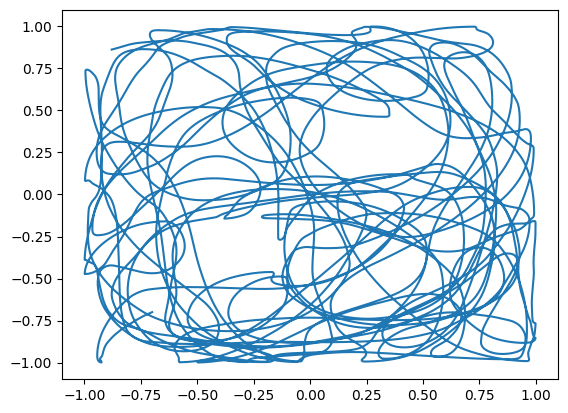

In [ ]:
##--------------------- LOAD TRAJECTORY --------------------###

with open(traj_path, "rb") as f:
    d = pickle.load(f)
    f.close()
locals().update(d)                      ###locals() function returns the dictionary of the current local symbol table.

if len(x) > 30000:                      ### dealing with 30001 entries mistake
  x = x[:-1]
  y = y[:-1]
  theta = theta[:-1]

x = np.asarray(x)
y = np.asarray(y)
theta = np.asarray(theta)
theta = np.nan_to_num(theta, nan=45.0)
theta_rad = np.radians(theta)

pos = np.column_stack((x,y))
env = [(1.0, -1.0), (1.0, 1.0), (-1.0, 1.0), (-1.0, -1.0), (1.0, -1.0)]
# sq1_env = box(-1.0, -1.0, 1.0, 1.0)
# sq1 = box(-0.7, -0.7, 0.7, 0.7)

obj_c = [(0.3, 0.3), (-0.3, -0.3)]
obj_c_plot = obj_c

hf_sz = 0.3 * 0.52                # scaled version according to unity
out_bound = 0.07
obj_ver = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c]
print("obj_ver", obj_ver)
obj_ver_outer = [(c[0]-hf_sz-out_bound, c[1]-hf_sz-out_bound, c[0]+hf_sz+out_bound, c[1]+hf_sz+out_bound) for c in obj_c]

# Cue card reward
# x_hf_sz = 0.2
# y_hf_sz = 0.005
# out_bound = 0.07  # padding
# obj_c = [(0.8, 0.5)]
# obj_ver_outer = [(c[0]-x_hf_sz-out_bound, c[1]-y_hf_sz-out_bound, c[0]+x_hf_sz+out_bound, c[1]+y_hf_sz+out_bound) for c in obj_c]


# Creating boxes for objects (sq2) and padding it (sq3)
sq1_env = box(-1.0, -1.0, 1.0, 1.0)
sq1 = box(-0.8, -0.8, 0.8, 0.8)
sq2 = [box(obj_ver[j][0], obj_ver[j][1], obj_ver[j][2], obj_ver[j][3]) for j in range(len(obj_ver))]       ### box with obj_ver coordinates - inner wall
sq3 = [box(obj_ver_outer[k][0], obj_ver_outer[k][1], obj_ver_outer[k][2], obj_ver_outer[k][3]) for k in range(len(obj_ver_outer))]      # outer wall
k1_env = list(sq1_env.exterior.coords)       ### 5 items cuz shapely polygons have counter-clockwise path notation
k1 = list(sq1.exterior.coords)
k2 = [list(l.exterior.coords) for l in sq2]
k3 = [list(ll.exterior.coords) for ll in sq3]

env = [[m[0] for m in k1_env ], [m[1] for m in k1_env ]]               # Isolating x and y coords
obj = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2]
obj_boun = [[[m[0] for m in objbi ], [m[1] for m in objbi ]] for objbi in k3]

# print(max(theta))
# print(len(theta))

# ## objects to do plotting that show shifting
obj_ver_plot = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c_plot]           ### QUES  - object modeled as square box? - yes
sq2_plot = [box(obj_ver_plot[j][0], obj_ver_plot[j][1], obj_ver_plot[j][2], obj_ver_plot[j][3]) for j in range(len(obj_ver_plot))]
k2_plot = [list(l.exterior.coords) for l in sq2_plot]
obj_plot = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2_plot]

# reward around the object
reward = rew_new(x, y, obj_ver_outer, present = obj_pres)
# # reward = [float(i) for i in reward]
print(len(reward))
plt.plot(x,y)
# ind = [i*30 for i in range(int(len(x)/30))]
# theta_norm = theta/max(theta)
# tar = np.asarray([x, y, theta_norm]).T

### for plotting without object, use empty list

###Reward & PI

In [ ]:
ja"""Population coding with multiple gaussian parts"""        # QUES - why all this to get tar? - pop coding much more accurate representation than predicting x,y directly

# Creating ground truth for mesh grid datapoints
num_images = theta.shape[0]
cos_theta = np.cos(np.deg2rad(theta))
sin_theta = np.sin(np.deg2rad(theta))

Hd_rep = np.column_stack((cos_theta, sin_theta))

out = 11
xmat = np.matlib.repmat(x.reshape((len(x),1)),1,11)     # each column is a 20k dimen trajectory x data, repeated across rows
ymat = np.matlib.repmat(y.reshape((len(y),1)),1,11)
print("len(x) - ", len(x))
xi = np.asarray(np.matlib.repmat(np.linspace(-1.0-0.4,1.0+0.4,num=out, endpoint=True), len(x),1))     # each row is one sequence of x values from -1.4 to 1.4 repeated down columns
yi = np.asarray(np.matlib.repmat(np.linspace(-1.0-0.4,1.0+0.4,num=out, endpoint=True), len(y),1))

### Gaussian representation
x_rep = np.exp(-1*((xi-xmat)/std_dev)**2)
y_rep = np.exp(-1*((yi-ymat)/std_dev)**2)

rep = np.column_stack((x_rep, y_rep, Hd_rep))     # 2nd dimension - 22 + 22 + 2
rep2 = np.column_stack((x_rep, y_rep))
print("rep2 shape - ", rep2.shape)

#Population code for theta for mesh grid data
ui_x = np.cos(np.linspace(0, 2*np.pi ,num=11, endpoint = False))
ui_y = np.sin(np.linspace(0, 2*np.pi ,num=11, endpoint = False))
ui = np.column_stack((ui_x, ui_y))
Hd_out_pop = np.matmul(Hd_rep, ui.T)     # similarity of theta across 11 samples
print("Hd_out_pop - ", Hd_out_pop.shape)

# reward = rew(x , y, theta, k2, k3, True)                          # QUES - what is this?
# dataRObj = pd.read_csv(data_fol+ "dataRewardObj.csv")
# dataRObj = np.asarray(dataRObj)
# reward = dataRObj[:,4]
# print(len(reward))
# for i in range(10):
#   plt.plot(Hd_out_pop[i,:])
#   plt.show()

comp_gt = np.column_stack((rep2, Hd_out_pop, reward))
tar = comp_gt        # complete x_rep(11 columns) + y_rep(11) + HD_out_pop(11) + reward(1)
comp_gt.shape

len(x) -  30000
rep2 shape -  (30000, 22)
Hd_out_pop -  (30000, 11)


(30000, 34)

In [ ]:
def PI(x, y, theta_rad, beta, pi_use, n=100, ):
  print(pi_use)
  if pi_use == "no_osc":
    #Calculating distance from starting point
    print("------using PI WITHOUT oscillators-----")
    pos = np.column_stack((x,y))
    a = pos[0,0] * np.ones(pos[:,0].shape)
    b = pos[0,1] * np.ones(pos[:,1].shape)
    origin = np.transpose(np.append([a],[b],axis=0)) #for different x,y

    disp = pos - origin

    # Head direction parameters
    dth = np.divide(2*np.pi, n)
    theta_pref = np.arange(0, 2*np.pi, dth)
    pref_dir = np.transpose([np.cos(theta_pref), np.sin(theta_pref)])
    print("len(pos)", len(pos))
    print("shape pref_dir", pref_dir.shape)
    hdi = preprocessing.normalize(np.cos(np.matlib.repmat(theta_pref, len(pos),1) - np.transpose((np.matlib.repmat(theta_rad[0:len(pos)],n, 1)))), norm='l2')

    # HD responses
    hd_resp = []
    for i in range(len(disp)):
        for j in range(len(pref_dir)):
            z = np.array(disp[i])
            dj = np.array(pref_dir[j])
            hd_resp.append(np.dot(z,dj))                                      #THE z.ui step
    hd_resp = np.transpose(np.reshape(hd_resp, (len(disp),len(pref_dir))))
    print("hd_resp shape", hd_resp.shape)

    # path integraion
    pi_layer_beta = []
    for i in range(len(beta)):
        pi_layer_temp = np.sin(beta[i] * hd_resp)           ### QUES - why not cos - does not matter much
        pi_layer_beta.append((pi_layer_temp))
    pi_layer_beta = np.asarray(pi_layer_beta)
    pi_beta = pi_layer_beta[0]
    for i in range(len(beta) - 1):
        pi_beta = np.concatenate((pi_beta, pi_layer_beta[i+1]))
    pi_lay = pi_beta.T
    print("pi_lay shape", pi_lay.shape)

  return pi_lay

In [ ]:
###------- Plot reward-------######
# plt.plot(reward)
# plt.show()
from scipy.ndimage import gaussian_filter
import scipy
from scipy import signal, ndimage
# print(np.sum(reward))
# title = "pred reward without object"
# kk = firing_rate_map(reward[ind], pos[ind], title = title)
# plt.imshow(kk)
# plt.show()

###------- Load Images -------######
print("------------------------Load Images-----------------------------")
with open(imgs_path, "rb") as f:
    train_imgs = pickle.load(f)
    f.close()

print(train_imgs.shape)


#### --------- Path Integration  --------####
print("------------------Calculate PI------------------------")
beta = [2*np.pi]           # beta values controls scale of model - beta=1 for place cells, zoom out to beta=3 for grid cells
pi_lay = PI(x, y, theta_rad, beta, pi_use)


------------------------Load Images-----------------------------
(30000, 32, 32, 3)
------------------Calculate PI------------------------
no_osc
------using PI WITHOUT oscillators-----
len(pos) 30000
shape pref_dir (100, 2)
hd_resp shape (100, 30000)
pi_lay shape (30000, 100)


In [ ]:
def seq_data(data, seq_len):
  temp1 = []

  for i in range(seq_len, data.shape[0]):
    temp3 = data[i-seq_len:i]
    temp1.append(temp3)
  temp1 = np.asarray(temp1)

  return temp1

In [ ]:
### ---------  Split the data  -------####
print("----------------Split data in test and train----------------")
from sklearn.model_selection import train_test_split
seq_len = 1

pi_seq = seq_data(pi_lay, seq_len)
print("pi_seq shape ", pi_seq.shape)
train_imgs_seq = seq_data(train_imgs, seq_len)
# r_seq = seq_data(reward, seq_len)
# print(train_imgs_seq.shape)

sub_imgs = train_test_split(train_imgs, test_size=0.2, random_state=random_state)        # list of train set + test set
sub_pi = train_test_split(pi_lay, test_size=0.2, random_state=random_state)
# sub_r = train_test_split(reward, test_size=0.2, random_state=random_state)
sub_tar = train_test_split(tar, test_size=0.2, random_state=random_state)


sub_pi_t = sub_pi
sub_imgs_t = sub_imgs
sub_tar_t = sub_tar
# sub_r_t = sub_r
comp_data = [train_imgs, pi_lay]

print("sub_pi_t[0].shape, sub_pi_t[1].shape")
print(sub_pi_t[0].shape, sub_pi_t[1].shape)
print("sub_imgs_t[0].shape, sub_imgs_t[1].shape")
print(sub_imgs_t[0].shape, sub_imgs_t[1].shape)
print("sub_tar_t[0].shape, sub_tar_t[1].shape")
print(sub_tar_t[0].shape, sub_tar_t[1].shape)

### ---------  Setup Learning Schedule  -------####
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learn_rate,
    decay_steps=10000,
    decay_rate=0.98,
    staircase=True)



----------------Split data in test and train----------------
pi_seq shape  (29999, 1, 100)
sub_pi_t[0].shape, sub_pi_t[1].shape
(24000, 100) (6000, 100)
sub_imgs_t[0].shape, sub_imgs_t[1].shape
(24000, 32, 32, 3) (6000, 32, 32, 3)
sub_tar_t[0].shape, sub_tar_t[1].shape
(24000, 34) (6000, 34)


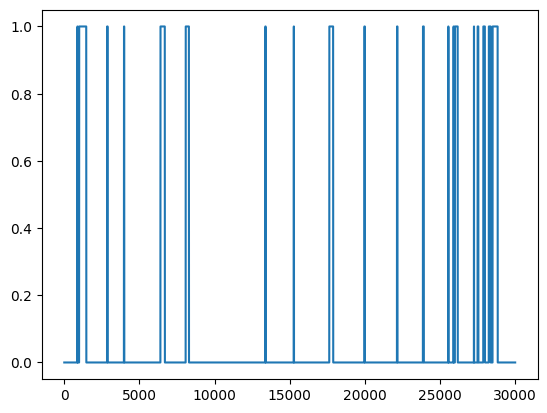

In [ ]:
plt.plot(reward)

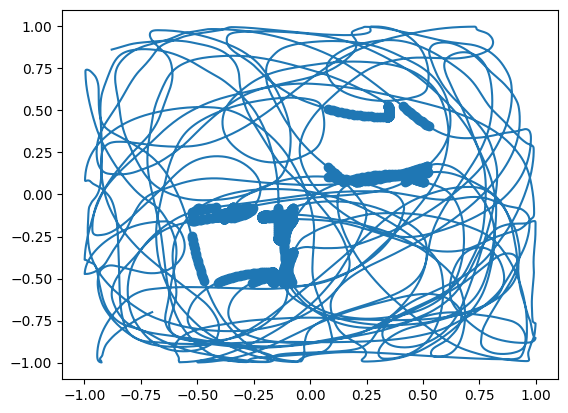

In [ ]:
# Reward check
kk = np.where(reward == 1)
plt.plot(x,y)
plt.scatter(x[kk], y[kk])
plt.show()

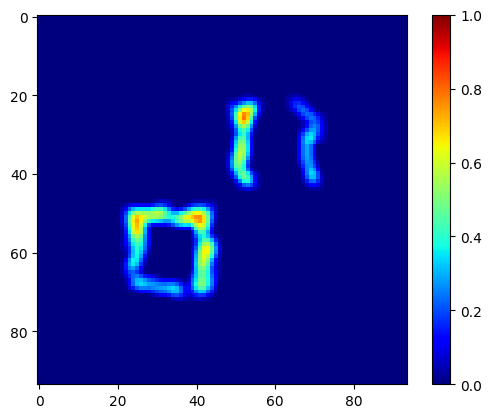

In [ ]:
firing_map = firing_rate_map(reward, pos, title = '', thresh_sd = False)
# plt.imshow(firing_map)
plt.show()
# print(sum(reward))

# Model

In [ ]:
def custom_weight_loss(y_true, y_pred):
  global alp, bet, gam
  y_diff = y_true - y_pred
  y_sq = tf.square(y_diff)

  # alp_mat = alp*tf.ones(tf.shape(y_sq[:, :22]))
  # bet_mat = bet*tf.ones(tf.shape(y_sq[:, 22:33]))
  # gam_mat = tf.expand_dims(gam*tf.ones(tf.shape(y_sq[:, -1])), ax is=1)
  # print(alp_mat.shape)
  # print(bet_mat.shape)
  # print(gam_mat.shape)
  # weighted_ratios = tf.concat([alp_mat, bet_mat, gam_mat], axis=1)
  # print(tf.shape(weighted_ratios))
  # y_loss = tf.math.multiply(weighted_ratios, y_sq)
  t_loss = alp*tf.reduce_mean(y_sq[:,:22]) + bet*tf.reduce_mean(y_sq[:,22:33]) + gam*tf.reduce_mean(y_sq[:,-1])

  return t_loss

### GraphConv

In [ ]:
class GraphLayer(keras.layers.Layer):

    def __init__(self,step_num=1,activation=None,**kwargs):
        """Initialize the layer.
        :param step_num: Two nodes are considered as connected if they could be reached in `step_num` steps.
        :param activation: The activation function after convolution.
        :param kwargs: Other arguments for parent class.
        """
        self.supports_masking = True
        self.step_num = step_num
        self.activation = keras.activations.get(activation)
        self.supports_masking = True
        super(GraphLayer, self).__init__(**kwargs)

    def get_config(self):
        config = {'step_num': self.step_num,'activation': self.activation,}
        base_config = super(GraphLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def _get_walked_edges(self, edges, step_num):
        """Get the connection graph within `step_num` steps
        :param edges: The graph in single step.
        :param step_num: Number of steps.
        :return: The new graph that has the same shape with `edges`.
        """
        if step_num <= 1:
            return edges
        deeper = self._get_walked_edges(K.batch_dot(edges, edges), step_num // 2)
        if step_num % 2 == 1:
            deeper += edges
        return K.cast(K.greater(deeper, 0.0), K.floatx())

    def call(self, inputs, **kwargs):
        features, edges = inputs
        edges = K.cast(edges, K.floatx())
        if self.step_num > 1:
            edges = self._get_walked_edges(edges, self.step_num)
        outputs = self.activation(self._call(features, edges))
        return outputs

    def _call(self, features, edges):
        raise NotImplementedError('The class is not intended to be used directly.')


class GraphConv(GraphLayer):
    r"""Graph convolutional layer.
    h_i^{(t)} = \sigma \left ( \frac{ G_i^T (h_i^{(t - 1)} W + b)}{\sum G_i}  \right )
    """

    def __init__(self,units,kernel_initializer='glorot_uniform', kernel_regularizer=None,kernel_constraint=None,use_bias=True,bias_initializer='zeros',bias_regularizer=None,bias_constraint=None,**kwargs):
        """Initialize the layer.
        :param units: Number of new states. If the input shape is (batch_size, node_num, feature_len), then the output
                      shape is (batch_size, node_num, units).
        :param kernel_initializer: The initializer of the kernel weight matrix.
        :param kernel_regularizer: The regularizer of the kernel weight matrix.
        :param kernel_constraint:  The constraint of the kernel weight matrix.
        :param use_bias: Whether to use bias term.
        :param bias_initializer: The initializer of the bias vector.
        :param bias_regularizer: The regularizer of the bias vector.
        :param bias_constraint: The constraint of the bias vector.
        :param kwargs: Other arguments for parent class.
        """
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.use_bias = use_bias
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.bias_constraint = keras.constraints.get(bias_constraint)

        self.W, self.b = None, None
        super(GraphConv, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'use_bias': self.use_bias,
            'bias_initializer': keras.initializers.serialize(self.bias_initializer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
        }
        base_config = super(GraphConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        feature_dim = int(input_shape[0][-1])
        self.W = self.add_weight(
            shape=(feature_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='{}_W'.format(self.name),
        )
        if self.use_bias:
            self.b = self.add_weight(
                shape=(self.units,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='{}_b'.format(self.name),
            )
        super(GraphConv, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + (self.units,)

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            mask = [None]
        return mask[0]

    def _call(self, features, edges):
        print('it came here')
        proj = K.dot(features, self.W)
        if self.use_bias:
            proj += self.b
        if self.step_num > 1:
            edges = self._get_walked_edges(edges, self.step_num)

        # aggr = proj/2
        aggr = tf.math.divide((K.sum(proj, axis=1, keepdims=True) + K.epsilon()), 3)
        # aggr = K.batch_dot(K.permute_dimensions(edges, (0, 2, 1)), proj) \
        #     / (K.sum(edges, axis=2, keepdims=True) + K.epsilon())
        return features + aggr
        # return features

### Model

In [ ]:
def model_arch(data, nodes, nodes2, activ, lr):                                    # QUES - architecture not similar to repo image - repo outdated, 1 CONV layer is suitable, more layers do not give appropriate results
  print("#########-----------------TRAINING MODEL---------------#########")
  act = 'leaky_relu'
  input_img = Input(shape = data[0].shape[1:], name="IMAGE") # (32,32,3)
  input_pi = Input(shape = data[1].shape[1], name="PI")       # (100)

  encoder = Conv2D(4, (5, 5), padding='same', name="CONV_1")(input_img)
  encoder = LeakyReLU()(encoder)
  encoder = MaxPooling2D(pool_size=(8,8), padding='same', name="MAXPOOL_1")(encoder)
  flatencoder=Flatten()(encoder)
  #flatencoder = GlobalAveragePooling2D()(encoder)
  dense0 = Dense(nodes, name='LEC')(flatencoder)
  dense0 = LeakyReLU()(dense0)

  dense_pi1 = Dense(nodes, name='MEC')(input_pi)
  dense_pi1 = LeakyReLU()(dense_pi1)
  dense_pi1 = layers.Reshape((1,nodes))(dense_pi1)

  dense0 = layers.Reshape((1,nodes))(dense0)
  data_layer = layers.concatenate([dense0, dense_pi1], axis=1)
  print("data_layer_shape", data_layer.shape)

  edge_layer = tf.constant(np.matlib.repmat(np.asarray([[1/3,1/3], [1/3,1/3]]), 1, 1).reshape((1,2,2)))
  conv_layer = GraphConv(units=nodes, step_num=1)([data_layer, edge_layer])
  conv_layer0 = Flatten()(conv_layer)
  dense1 = Dense(nodes2, activation = activ, name = 'D1')(conv_layer0)
  # dense1 = BatchNormalization()(dense1)
  dense2 = Dense(nodes2, activation = activ, name = 'D2')(dense1)
  dense3 = Dense(nodes2, activation = activ, name = 'D3')(dense2)
  # dense4 = Dense(8, activation = activ, name = 'D4')(dense3)

  """3 dense layers"""
  output1 = Dense(22, activation='tanh', name='VALUE1')(dense3)
  output2 = Dense(11, activation='tanh', name='VALUE2')(dense3)
  output3 = Dense(1, activation='tanh', name='VALUE3')(dense3)
  output = layers.concatenate([output1, output2, output3], axis=1)
  #
  regressor_model = Model([input_img, input_pi], output)
  #regressor_model = Model([input_img,], [outputx, outputy, outputz])
  opt = tf.keras.optimizers.Adam(learning_rate= lr)
  regressor_model.compile(optimizer=opt, loss = custom_weight_loss, )
  # regressor_model.summary()

  return regressor_model

In [ ]:
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.regularizers import l2
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.constraints import max_norm

# Train the model
if Train:
  tf.keras.backend.clear_session()
  model = model_arch(comp_data, nodes = units, nodes2=units2, activ = 'leaky_relu', lr = lr_schedule)
  model.summary()


## If retrain the model
if Retrain:
  opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

  if Retrain_nocat:
    keras.backend.clear_session()
    model = model_arch(comp_data, nodes = units, nodes2=units2, activ = 'leaky_relu', lr = learn_rate)

    # if custom_loss_func:
    #   opt = tf.keras.optimizers.SGD(learning_rate = 1.0)
    #   model.compile(optimizer = opt, loss = custom_lr_loss, )
    # else:
    #   model.compile(optimizer = opt, loss = 'mse', )


  else:

    # with open(fol+"mod_dict_" + old_model_n + ".pk1", "rb") as f:
    with open(fol+ "mod_dict_" + old_model_n +".pk1", "rb") as f:
      old_mod_dict = pickle.load(f)
      f.close()

    model = model_arch_catas(comp_data, old_mod_dict, nodes=units, nodes2=units2, lam=lam, activ = 'leaky_relu')
    model.compile(optimizer = opt, loss = custom_weight_loss, )

    # if custom_loss_func:
    #   opt = tf.keras.optimizers.SGD(learning_rate = 1.0)
    #   model.compile(optimizer = opt, loss = custom_lr_loss, )
    # else:
    #   model.compile(optimizer = opt, loss = 'mse', )

  print("Loading weights from previous model")
  model.load_weights(fol + old_model_n +".h5")
  model.summary()

#########-----------------TRAINING MODEL---------------#########
data_layer_shape (None, 2, 32)
it came here
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 IMAGE (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 CONV_1 (Conv2D)                (None, 32, 32, 4)    304         ['IMAGE[0][0]']                  
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 4)    0           ['CONV_1[0][0]']                 
                                                                                                  
 MAXPOOL_1 (MaxPooling2D)       (None, 4, 4, 4)      0           ['leaky_re_lu[0][0]

In [ ]:
# if Train:
#   train_dat = [sub_imgs_t[0], sub_pi_t[0]]
#   train_tar = sub_tar_t[0]

#   ii = 0
#   # for ii in range(1):
#   while True:
#       num_images = pos[0]-1
#       loss = []
#       val_loss = []
#       history = model.fit(
#                 train_dat,                           # QUES - why these 2 sets ? - train_dat is [sub_imgs_t[0], sub_pi_t[0]] - (32,32,3) + (100), train_tar is 34 columned (final prediction - pop coding form)
#                 train_tar,
#                 epochs = 2,
#                 batch_size = 32,
#                 validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_tar_t[1]),
#                 shuffle = True,
#                 verbose = 2)

#       ii+=1
#       print(ii)

#       if (history.history['loss'][0] <= 10**-3 and history.history['val_loss'][0] <= 10**-3) or ii > epochs:
#         break



# Fixed number of epochs
if Train:
  train_dat = [sub_imgs_t[0], sub_pi_t[0]]
  train_tar = sub_tar_t[0]

  ii = 0
  # for ii in range(1):

  num_images = pos[0]-1
  loss = []
  val_loss = []
  history = model.fit(
            train_dat,          # QUES - why these 2 sets ? - train_dat is [sub_imgs_t[0], sub_pi_t[0]] - (32,32,3) + (100), train_tar is 34 columned (final prediction - pop coding form)
            train_tar,
            epochs = epochs,
            batch_size = 64,
            validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_tar_t[1]),
            shuffle = True,
            verbose = 2)


Epoch 1/50
it came here
it came here
it came here
375/375 - 9s - loss: 0.0127 - val_loss: 0.0056 - 9s/epoch - 25ms/step
Epoch 2/50
375/375 - 2s - loss: 0.0057 - val_loss: 0.0041 - 2s/epoch - 5ms/step
Epoch 3/50
375/375 - 2s - loss: 0.0044 - val_loss: 0.0041 - 2s/epoch - 5ms/step
Epoch 4/50
375/375 - 2s - loss: 0.0042 - val_loss: 0.0034 - 2s/epoch - 4ms/step
Epoch 5/50
375/375 - 2s - loss: 0.0035 - val_loss: 0.0029 - 2s/epoch - 4ms/step
Epoch 6/50
375/375 - 2s - loss: 0.0039 - val_loss: 0.0046 - 2s/epoch - 6ms/step
Epoch 7/50
375/375 - 2s - loss: 0.0034 - val_loss: 0.0033 - 2s/epoch - 6ms/step
Epoch 8/50
375/375 - 2s - loss: 0.0031 - val_loss: 0.0040 - 2s/epoch - 5ms/step
Epoch 9/50
375/375 - 2s - loss: 0.0028 - val_loss: 0.0030 - 2s/epoch - 4ms/step
Epoch 10/50
375/375 - 2s - loss: 0.0033 - val_loss: 0.0036 - 2s/epoch - 4ms/step
Epoch 11/50
375/375 - 2s - loss: 0.0030 - val_loss: 0.0047 - 2s/epoch - 5ms/step
Epoch 12/50
375/375 - 2s - loss: 0.0027 - val_loss: 0.0037 - 2s/epoch - 5ms/st

In [ ]:
model.save(fol2 + new_model_n +".h5")
wts = model.weights
print(wts[-1])

<tf.Variable 'VALUE3/bias:0' shape=(1,) dtype=float32, numpy=array([0.01646453], dtype=float32)>


In [ ]:
if Retrain:
  error_x = []
  error_y = []
  error_a = []
  # error_old = []

  train_dat = [sub_imgs_t[0], sub_pi_t[0]]
  train_tar = sub_tar_t[0]

  # predicted_r = model.predict(comp_data)
  # predicted_r_old = model.predict(comp_data_old)
  # firing_rate_map(predicted_r[ind], pos[ind])

  # error_current.append(mse(predicted_r,reward))
  # error_old.append(mse(predicted_r_old,reward_old))

  # for ii in range(epochs)):
  ii = 0
  while True:
      num_images = pos[0]-1
      loss = []
      val_loss = []
      history = model.fit(
                train_dat,
                train_tar,
                epochs = 1,
                batch_size = 256 ,
                validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_tar_t[1]),
                shuffle = True, verbose=2)

      ii+=1
      print(ii)
      predicted_r = model.predict(comp_data)
      curr_err = mse(predicted_r[:,-1], reward)
      if not Retrain_nocat:
        mod_lays = model.layers
        reg_loss_arr = [ll.losses[0] for ll in mod_lays if len(ll.losses)]
        reg_loss_tot = (K.eval(sum(reg_loss_arr)))/len(reg_loss_arr)
        print("loss from regularizer: " + str(reg_loss_tot/lam))
        print('loss from model:' + str(curr_err))
        # if (history.history['loss'][0] < 10**-3 and history.history['val_loss'][0] < 10**-3 and (reg_loss_tot/lam) < 10**-4) or ii > epochs:
        if (curr_err < 10**-3 and (reg_loss_tot/lam) < 10**-4) or ii>epochs:
          break

      if Retrain_nocat:
        if (history.history['loss'][0] < 10**-3 and history.history['val_loss'][0] < 10**-3) or ii > epochs:
          break
      # if ii % 10 == 0:

      # error_x.append(mse(xya_pred[:,0],tar[:,0]))
      # error_y.append(mse(xya_pred[:,1],tar[:,1]))
      # error_a.append(mse(xya_pred[:,2],tar[:,2]))
      # predicted_r_old = model.predict(comp_data_old)
      # error_old.append(mse(predicted_r_old,reward_old))
      # plt.plot(error_current, label='error_c')
      # plt.plot(error_old, label='error_o')
      # plt.show()
      # print(error_current[-1])

      # if not Retrain_nocat:
      # if True:
      #   if True:
      #   # if ii % 10 == 0:
      #     plt.legend()
      #     plt.show()

      #     lr_p = lr_p*0.98
      #     lr_m = lr_m*0.99
      #     print('it came here')
      #     model.save(fol+ new_model_n +".h5")
      #     wts = model.weights

      #     keras.backend.clear_session()
      #     model = model_arch_catas(train_dat, old_mod_dict, nodes=units, nodes2 = units2, lam = lam, activ = 'sigmoid')
      #     model.compile(optimizer = opt, loss = 'mse', )
      #     print("Loading weights from previous model")
      #     model.load_weights(fol+ new_model_n +".h5")

      # firing_rate_map(predicted_r[ind], pos[ind], ticks_colbar = np.linspace(0, 1, 5))

  model.save(fol2 + new_model_n +".h5")
  wts = model.weights
  print(wts[-1])


#LAYERWISE OUTPUT ANALYSIS

In [ ]:
"""for loading weights of model 1 and testing on train3 - trace cell case"""

tf.keras.backend.clear_session()
autoencoder_model = model_arch(comp_data, nodes = units, nodes2=units2, activ = 'leaky_relu', lr = lr_schedule)
autoencoder_model.load_weights(fol2 + new_model_n +".h5")
# autoencoder_model.load_weights(fol2 + "Xcue_v5_obj_110.1.h5")
outputs  = [layer.output for layer in autoencoder_model.layers]
encoded = {}

#########-----------------TRAINING MODEL---------------#########
data_layer_shape (None, 2, 32)
it came here


In [ ]:
predicted_r = autoencoder_model.predict(comp_data)

it came here
938/938 [==============================] - 2s 2ms/step


In [ ]:
def mse(data, pred_data):
  data = np.ndarray.flatten(data)
  pred_data = np.ndarray.flatten(pred_data)
  mse_ = np.sum(np.square(data - pred_data))/len(data)
  return mse_

In [ ]:
k = predicted_r
seq_len = 1
test = False
temp_x_num = np.sum(np.multiply(xi,k[:,:11]), axis = 1)        # QUES - sort of an inverse process to the gaussian pop coding earlier? - yes, mean of gaussian calculated from 11 samples for x and y, however theta reconstruction is unclear atm
temp_x_den = np.sum(k[:, :11], axis = 1)
temp_y_num = np.sum(np.multiply(yi,k[:,11:22]), axis = 1)
temp_y_den = np.sum(k[:, 11:22], axis = 1)
temp_theta_num = np.matmul(k[:,22:-1], ui)*2/11
x_pred = temp_x_num/temp_x_den
y_pred = temp_y_num/temp_y_den

# # splitting predictions into predictions on train and predictions on test and plotting them later
# sub_x_pred = train_test_split(x_pred, test_size=0.2, random_state=random_state)
# sub_x = train_test_split(x, test_size=0.2, random_state=random_state)
# sub_y_pred = train_test_split(y_pred, test_size=0.2, random_state=random_state)
# sub_y = train_test_split(y, test_size=0.2, random_state=random_state)
# sub_Hd_rep = train_test_split(Hd_rep, test_size=0.2, random_state=random_state)
# sub_temp_theta_num = train_test_split(temp_theta_num, test_size=0.2, random_state=random_state)

# temp = np.column_stack((sub_x[0], sub_x_pred[0]))
# # print(temp[:30])

# test = 1
# plt.scatter(sub_x[test], sub_x_pred[test])
# if test:
#   plt.title("prediction for test data for x_cord")
# else:
#   plt.title("prediction for train data for x_cord")
# plt.xlabel("actual x")
# plt.ylabel("predicted x")
# plt.ylim(-1.05,1.05)
# plt.show()
# error_x = mse(sub_x[test],sub_x_pred[test])
# print("mse error in x:",error_x)
# print("")


# plt.scatter(sub_y[test], sub_y_pred[test])
# if test:
#   plt.title("prediction for test data for y_cord")
# else:
#   plt.title("prediction for train data for y_cord")
# plt.xlabel("actual y")
# plt.ylabel("predicted y")
# plt.ylim(-1.05,1.05)
# plt.show()
# error_y = mse(sub_y[test],sub_y_pred[test])
# print("mse error in y:",error_y)
# print("")


# plt.scatter(sub_Hd_rep[test][:,0], sub_temp_theta_num[test][:,0])
# if test:
#   plt.title("prediction for test data for cos_theta")
# else:
#   plt.title("prediction for train data for cos_theta")
# plt.xlabel("actual cos_theta")
# plt.ylabel("predicted cos_theta")
# plt.show()
# error_cos = mse(sub_Hd_rep[test][:,0], sub_temp_theta_num[test][:,0])
# print("mse error in cos:" ,error_cos)
# print("")


# plt.scatter(sub_Hd_rep[test][:,1], sub_temp_theta_num[test][:,1])
# if test:
#   plt.title("prediction for test data for sin_theta")
# else:
#   plt.title("prediction for train data for sin_theta")
# plt.xlabel("actual sin_theta")
# plt.ylabel("predicted sin_theta")
# plt.show()
# error_sin = mse(sub_Hd_rep[test][:,1], sub_temp_theta_num[test][:,1])
# print("mse error in sin:" ,error_sin)
# print("")


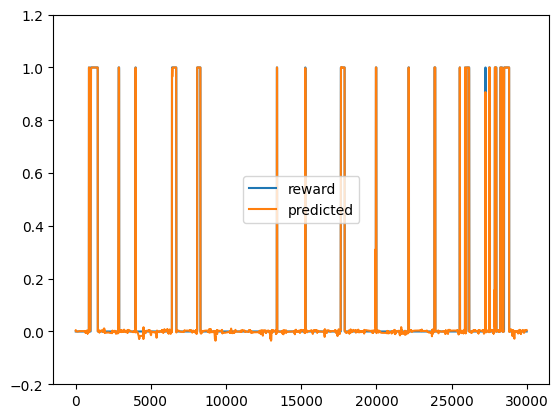

In [ ]:
plt.plot(reward, label = 'reward')
plt.plot(predicted_r[:,-1], label = 'predicted')
plt.ylim([-0.2,1.2])
plt.legend()
plt.show()

from scipy.ndimage import gaussian_filter
import scipy
from scipy import signal, ndimage
#ot = predicted_output[1][:,-1,:]
#ot = gt
# ot = np.ndarray.flatten(encoded['val'])
# predicted_r_old = autoencoder_model.predict(comp_data_old)
# firing_map = firing_rate_map(predicted_r_old, pos_old)
# firing_map = firing_rate_map(predicted_r[:,-1], pos)               # QUES - why are we supplying reward, shouldnt it be the firing value?

###Save and load layerwise output

In [ ]:
# # GET OUTPUT FOR THE REQUIRED LAYERS
# ind = [i*30 for i in range(int(len(x)/30))]

# if pre_conv:
#   inp = autoencoder_model.input
#   lay_nam = ['D1', 'D2','D3', 'LEC', 'MEC', 'graph_conv']
#   lim = [2]*7#, 0.5, 0.0]#, 0.4, 0.4]

#   encoded_pre = {}

#   for i in range(len(lay_nam)):
#     layer_output = autoencoder_model.get_layer(lay_nam[i]).output
#     functor = K.function(inp, layer_output)
#     temp1 = functor(comp_data)
#     if lay_nam[i] == 'graph_conv':                # QUES - why split into 2 layers - post conv layers (graph_LEC, graph_MEC) have superposition of view vector (streamplot) from LEC and grid cells from MEC
#       encoded_pre['graph_LEC'] = temp1[:,0,:]
#       encoded_pre['graph_MEC'] = temp1[:,1,:]
#     else:
#       encoded_pre[lay_nam[i]] = temp1

# # print(encoded_pre["D1"].shape)

#   from matplotlib.pyplot import close
#   outs = lay_nam[:-1] + ['graph_LEC', 'graph_MEC']
#   outs_n = lay_nam[:-1] + ["gr_LEC", "gr_MEC"]#, 'CA1']#, "CA1", "CA3"]
#   pos_out = pos

#   for k in range(len(outs)):
#     if outs[k] == 'rnn_1' or 'rnn_2':
#       resp_neurons = np.transpose(np.squeeze((encoded_pre[outs[k]])))
#     else:
#       print("encoded_pre layer shape for", outs[k], " s - ", encoded_pre[outs[k]].shape)
#       resp_neurons = np.squeeze(np.transpose(encoded_pre[outs[k]]))
#     avg = np.mean(abs(resp_neurons))
#     std_dev = np.std(resp_neurons)
#     m = np.amax(resp_neurons)
#     num = 0
#     for j in range(int(np.divide(len(resp_neurons),resp_neurons.shape[0]))):
#         onm = outs_n[k]
#         for i in range(resp_neurons.shape[0]):
#             axarr = plt.subplot(8,8,i+1)
#             img_dat = firing_rate_map(resp_neurons[i+num], pos_out, thresh_param=lim[k], res_param=45, sub_plot=True)
#             axarr.imshow(img_dat)

#             # plt.plot(env[0], env[1])
#             plt.suptitle('output mesh with obj '+str(num)+ ' to '+str(num+resp_neurons.shape[0])+' neurons from '+ onm +' layer, threshold=' +str(lim[k])+" act_func=" + "relu", fontsize = 20, va = 'bottom', ha = 'center')

#         # break
#         num = num + resp_neurons.shape[0]
#         figure = plt.gcf() # get current figure
#         figure.set_size_inches(14, 10)
#         # plt.savefig(fol2 + mesh_path + onm + "_" + str(traj1)[:-4] + "_" + str(num), bbox_inches='tight')
#         plt.show()
#         close()


In [ ]:
# with open(fol2 +"lay_out_train_v1" + ".pk1", 'wb') as ff:           # need to view this file
#     pickle.dump(encoded_pre, ff)
#     ff.close()

it came here
it came here
it came here
it came here


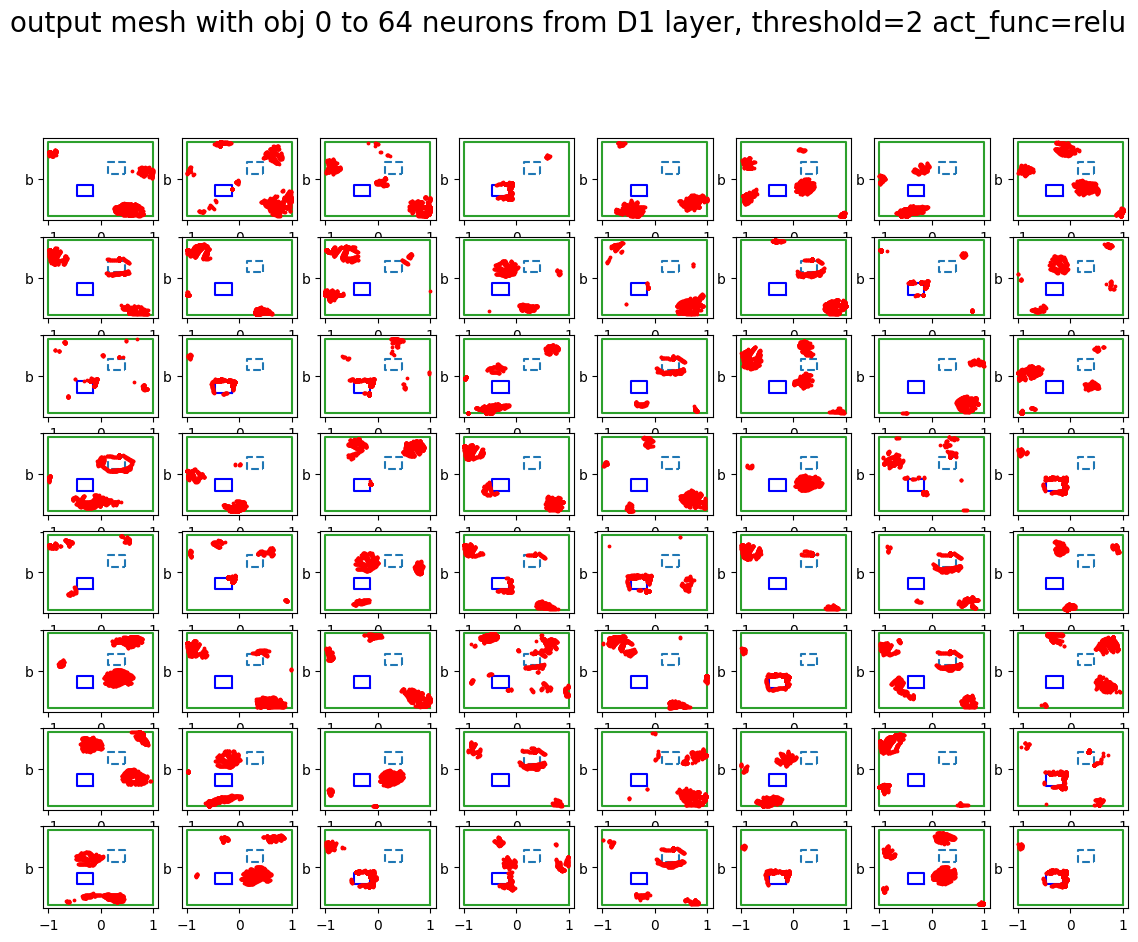

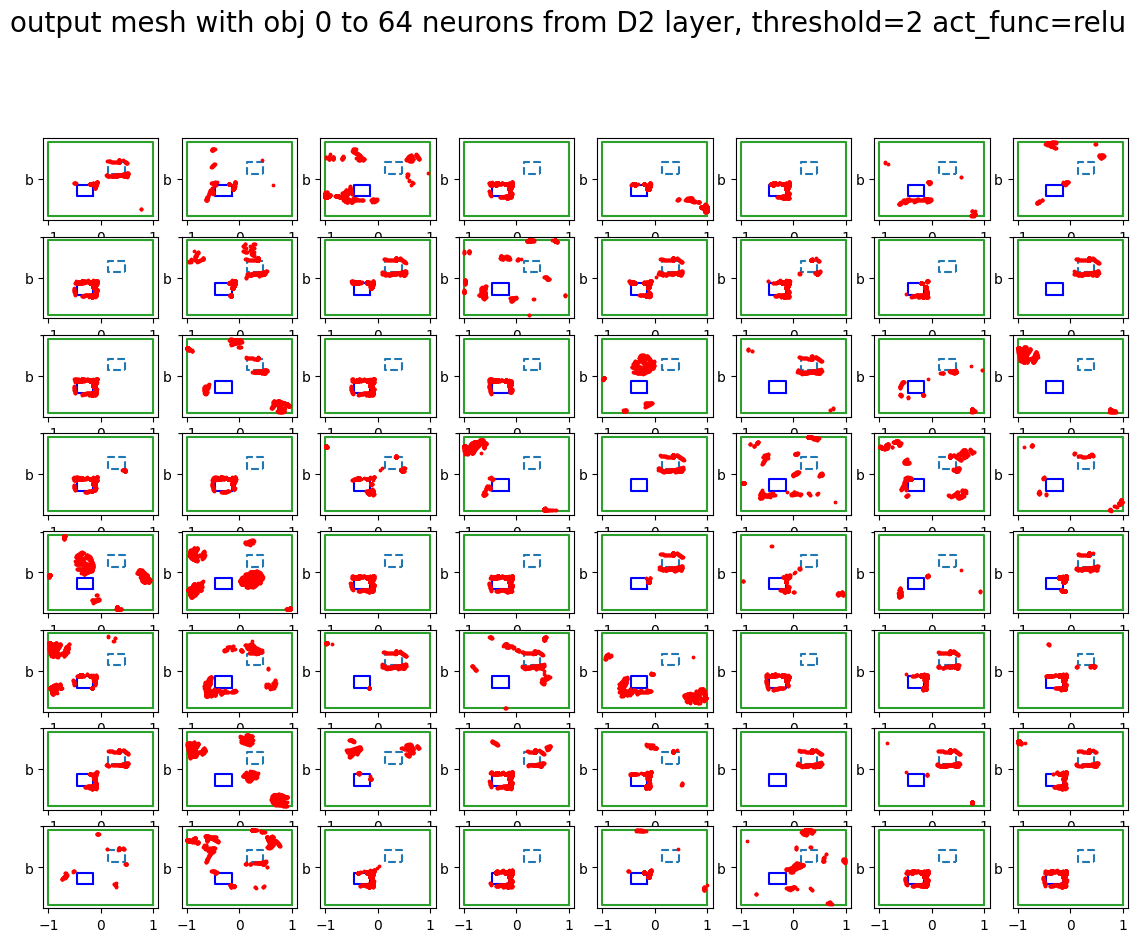

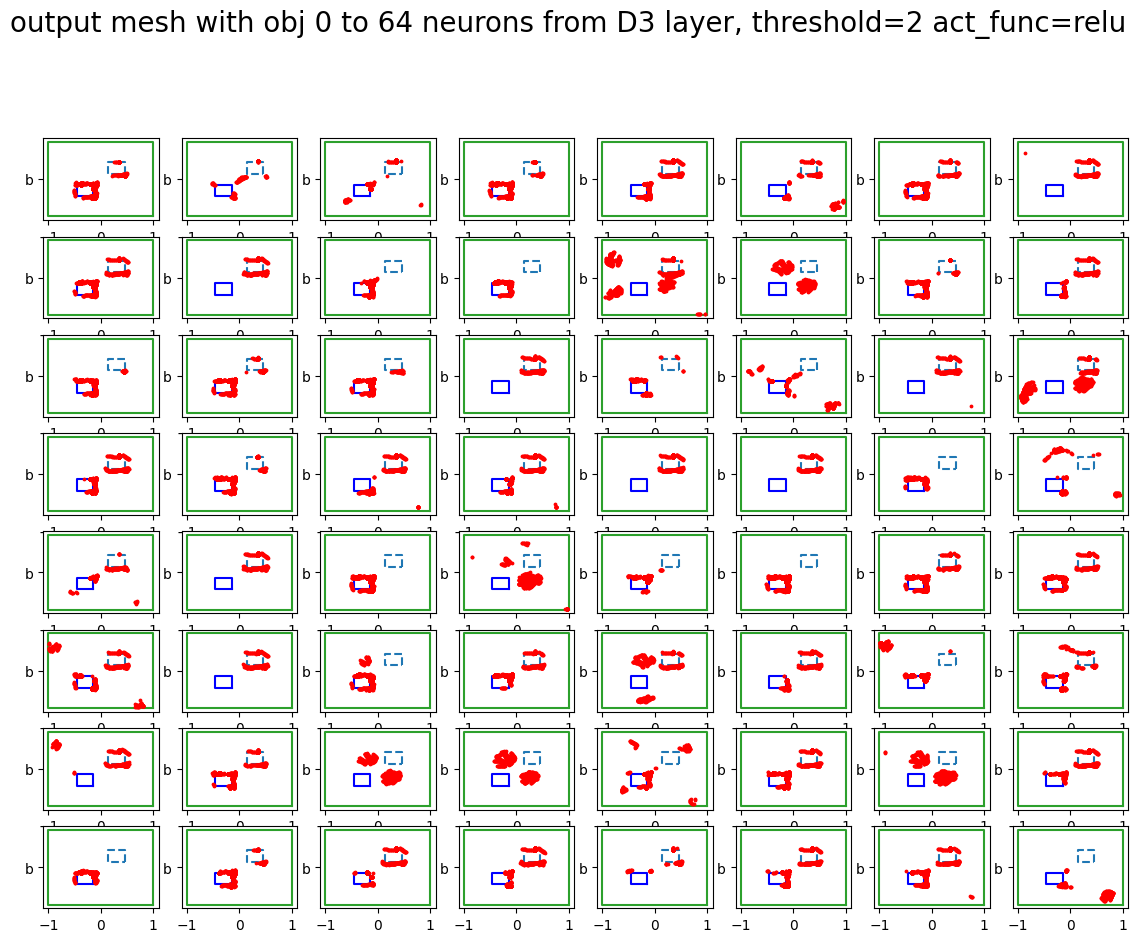

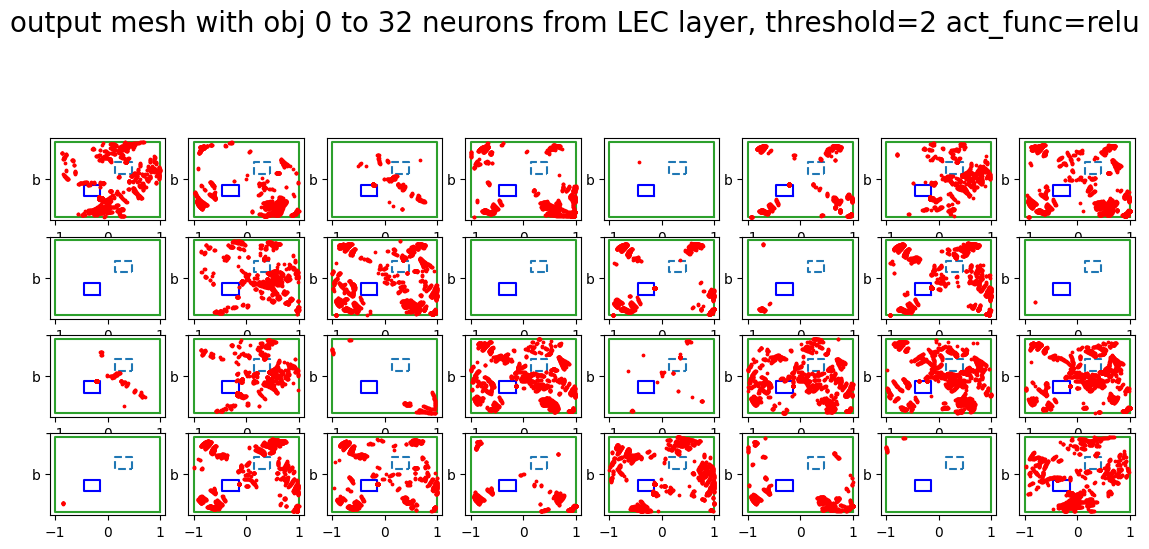

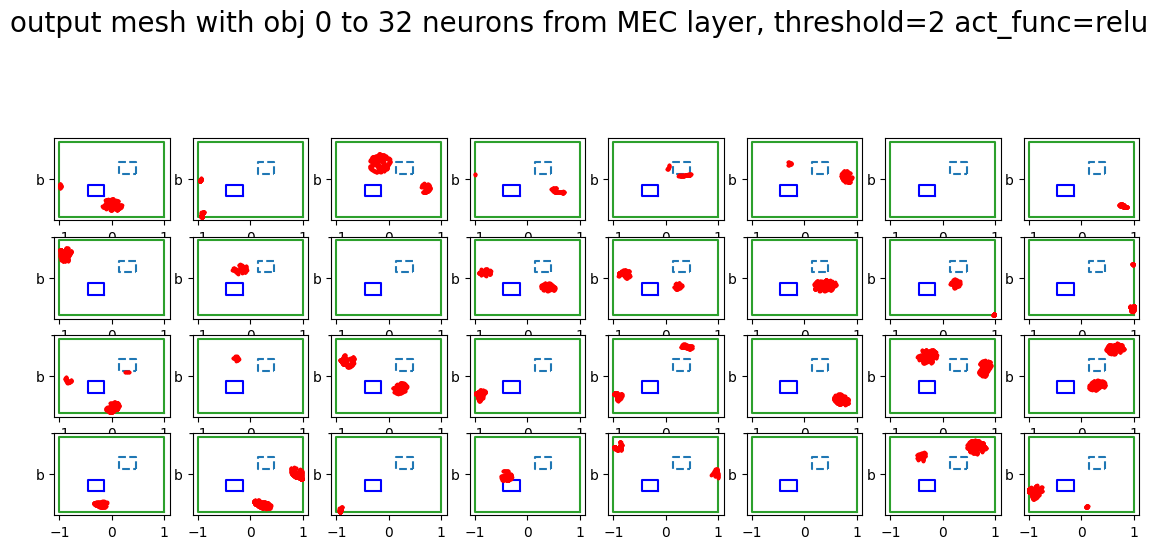

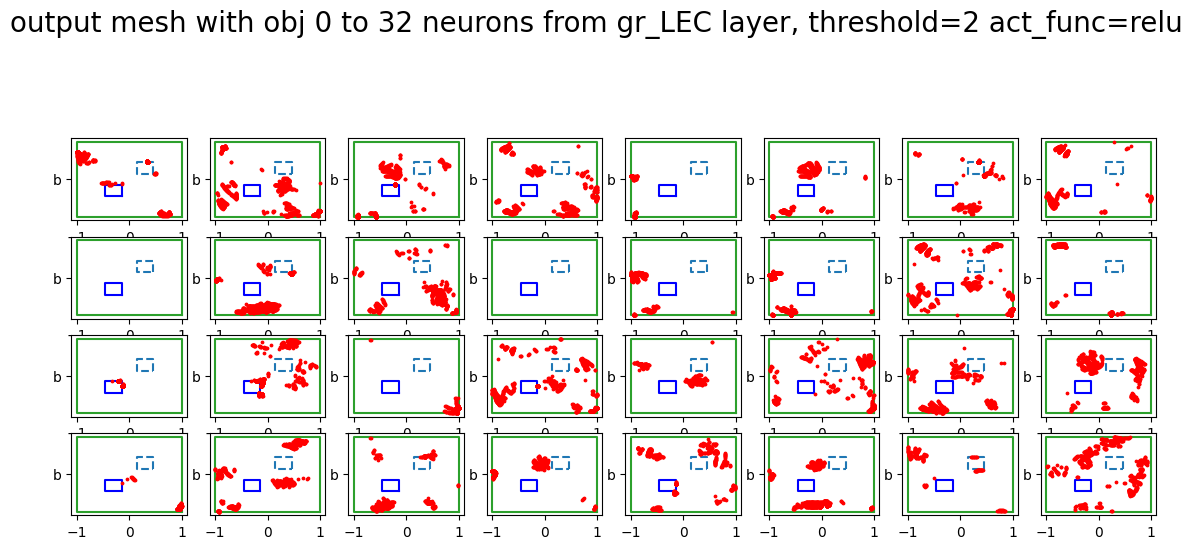

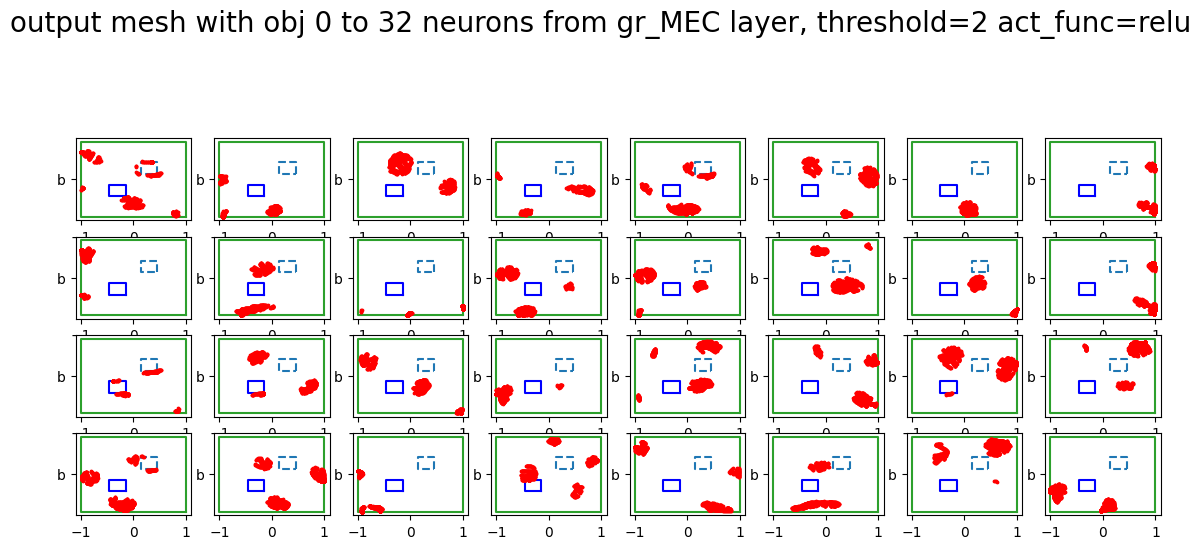

In [ ]:
# GET OUTPUT FOR THE REQUIRED LAYERS
if pre_conv:
  inp = autoencoder_model.input
  # lay_nam = ['D1', 'D2', 'graph_conv']
  # lim = [1.0, 1.0]#, 0.5, 0.0]#, 0.4, 0.4]
  lay_nam = ['D1', 'D2', 'D3', 'LEC', 'MEC', 'graph_conv']
  lim = [lem]*7 #, 0.5, 0.0]#, 0.4, 0.4]

  # lim = [1.5, 1.5, 1.5, 2.0, 1.5, 1.5, 1.5]#, 0.5, 0.0]#, 0.4, 0.4]

  encoded_pre = {}

  for i in range(len(lay_nam)):
    layer_output = autoencoder_model.get_layer(lay_nam[i]).output
    functor = K.function(inp, layer_output)
    temp1 = functor(comp_data)
    if lay_nam[i] == 'graph_conv':
      encoded_pre['graph_LEC'] = temp1[:,0,:]
      encoded_pre['graph_MEC'] = temp1[:,1,:]
    else:
      encoded_pre[lay_nam[i]] = temp1


#Spike
  from matplotlib.pyplot import close
  outs = lay_nam[:-1] + ['graph_LEC', 'graph_MEC']
  outs_n = lay_nam[:-1] + ["gr_LEC", "gr_MEC"]#, 'CA1']#, "CA1", "CA3"]
  pos_out = pos

  for k in range(len(outs)):
    if outs[k] == 'rnn_1' or 'rnn_2':
      resp_neurons = np.transpose(np.squeeze((encoded_pre[outs[k]])))
    else:
      resp_neurons = np.squeeze(np.transpose(encoded_pre[outs[k]]))
    avg = np.mean(abs(resp_neurons))
    std_dev = np.std(resp_neurons)
    m = np.amax(resp_neurons)
    num = 0
    for j in range(int(np.divide(len(resp_neurons),resp_neurons.shape[0]))):
        onm = outs_n[k]
        for i in range(resp_neurons.shape[0]):
            plt.subplot(8,8,i+1)
            mean_resp = np.mean(resp_neurons[i+num])
            std_resp = np.std(resp_neurons[i+num])
            thresh = mean_resp + (lim[k] * std_resp)
            # thresh = np.amax(resp_neurons[i+num]) * lim[k]
            firr = np.nonzero(resp_neurons[i+num]>thresh)
            firposgrid = pos_out[firr[0], :]
            plt.scatter(firposgrid[:,0], firposgrid[:,1], s = 3, color = 'red', marker='o', zorder = 5)
            if obj_pres:
              for tt in range(len(obj_plot)):
                if tt == len(obj_plot)-1:
                  plt.plot(obj_plot[tt][0], obj_plot[tt][1], 'b')
                else:
                  plt.plot(obj_plot[tt][0], obj_plot[tt][1],'--', 'b')
            else:
              for tt in range(len(obj_plot)):
                plt.plot(obj_plot[tt][0], obj_plot[tt][1],'--', 'b')

            plt.plot(env[0], env[1])
            plt.suptitle('output mesh with obj '+str(num)+ ' to '+str(num+resp_neurons.shape[0])+' neurons from '+ onm +' layer, threshold=' +str(lim[k])+" act_func=" + "relu", fontsize = 20, va = 'bottom', ha = 'center')

        num = num + resp_neurons.shape[0]
        figure = plt.gcf() # get current figure
        figure.set_size_inches(14, 10)

        fol_path = os.path.join(fol2, mesh_path)
        if not os.path.exists(fol_path):
          os.makedirs(fol_path)
        file_name = onm + "_red" + "_" + str(num) + '.png'
        file_path = os.path.join(fol_path, file_name)
        plt.savefig(file_path, bbox_inches='tight')

        plt.show()
        close()
